In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [10]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.5,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))


Gaussian
t_Copula
t_Copula_Capped
Clayton
Frank
Gumbel
Plackett
Gauss Mix Indep


In [4]:
k_arr = [10,20] # Absolute risk aversion for exponential risk measure
q_arr = [0.01,0.05,0.1] # Quantile level for expected shortfall

best_h = []
for C_name in Copulae:
    best_h.append(optimize_h(Copulae[C_name], k_arr, q_arr))

Optimization terminated successfully.
         Current function value: 0.000448
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.032501
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.041642
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.010071
         Iterations: 13
         Function evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000840
         Iterations: 13
         Function evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000094
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.002236
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

In [14]:
best_h = pd.DataFrame(best_h)
best_h.columns = ['Var'] + ['ERM k=%i'%k for k in k_arr] +  ['ES q=%.2f'%q for q in q_arr]
best_h.index = Copulae_names 
best_h

,Var,ERM k=10,ERM k=20,ES q=0.01,ES q=0.05,ES q=0.10
Gaussian,0.884082,0.896289,0.914648,0.842383,0.892480,8.582031e-01
t_Copula,0.098047,0.104395,0.105566,0.099902,0.096387,1.000000e-01
t_Copula_Capped,0.097754,0.104395,0.104395,0.098633,0.081250,8.720703e-02
Clayton,0.078223,0.106250,0.134668,0.064062,0.052930,-8.881784e-16
Frank,0.015332,0.015234,0.018066,0.016309,0.002539,-9.765625e-05
Gumbel,0.834375,0.960449,1.014648,0.871094,0.743652,6.247070e-01
Plackett,0.580371,0.589062,0.592773,0.601367,0.550000,5.404297e-01
Gauss Mix Indep,0.338672,0.356348,0.386426,0.301465,0.301660,3.898437e-01


In [336]:
data_name = "future_brr_v4"
data_path = "../processed_data/"+data_name+"/"

# Risk Measures
# Variance is automatically included
k_arr = [10,20] # Absolute risk aversion for exponential risk measure
q_arr_ES = [0.01,0.05,0.1] # Quantile level for expected shortfall

spot_name = "log return brr"
future_name = "log return future"

paras_results = []
likelihood_results = []
best_h_results = []

calibration_method = "MLE" # MM or MLE
q_arr = [0.05,0.1,0.9,0.95]

ls = os.listdir(data_path+'train/')
ls = [l for l in ls if l.endswith('.csv')]
for file in ls:
    # Calibration 
    train = pd.read_csv(data_path+'train/'+file)
    spot   = train.loc[:,spot_name]
    future = train.loc[:,future_name]
    u = ECDF(spot)(spot)
    v = ECDF(future)(future)
    
    kde_brr = KDE(spot, "Gaussian")
    kde_btc = KDE(future, "Gaussian")
    
    for C_name in Copulae:
        Copulae[C_name].Law_RS = kde_brr
        Copulae[C_name].Law_RF = kde_btc
    
    paras = []
    likelihood = []
    best_h = []
    for C_name in Copulae:
        if calibration_method == "MLE":
            Copulae[C_name].canonical_calibrate(u,v)
            
        elif calibration_method == "MM":
            Copulae[C_name].mm_calibrate(u,v,q_arr)

        print(C_name,'is done.\n')
    
    for C_name in Copulae:
        paras.append((C_name,Copulae[C_name].paras))
        
    for C_name in Copulae:
        ln = Copulae[C_name].dependency_likelihood(u,v)
        likelihood.append((C_name,ln))
        
    paras_results.append(paras)
    likelihood_results.append(likelihood)
    
    # Get Best h
    best_h = []
    for C_name in Copulae:
        best_h.append(optimize_h(Copulae[C_name], k_arr, q_arr_ES))
    best_h = pd.DataFrame(best_h)
    best_h.columns = ['Var'] + ['ERM k=%i'%k for k in k_arr] +  ['ES q=%.2f'%q for q in q_arr_ES]
    best_h.index = Copulae_names 
    best_h_results.append(best_h)
    
#     # Testing
#     test = pd.read_csv(data_path+'test/'+file)
#     spot_test   = train.loc[:,spot_name]
#     future_test = train.loc[:,future_name]

Optimization terminated successfully.
         Current function value: -0.416899
         Iterations: 32
         Function evaluations: 66
Gaussian is done.

Optimization terminated successfully.
         Current function value: -0.522612
         Iterations: 120
         Function evaluations: 231
t_Copula is done.

Optimization terminated successfully.
         Current function value: -0.502592
         Iterations: 176
         Function evaluations: 339
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.388826
         Iterations: 41
         Function evaluations: 91
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.422036
         Iterations: 42
         Function evaluations: 91
Frank is done.

Optimization terminated successfully.
         Current function value: -0.449668
         Iterations: 36
         Function evaluations: 79
Gumbel is done.

Optimization terminated successfully.
         

Optimization terminated successfully.
         Current function value: -0.428291
         Iterations: 123
         Function evaluations: 244
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.307838
         Iterations: 34
         Function evaluations: 74
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.371233
         Iterations: 35
         Function evaluations: 77
Frank is done.

Optimization terminated successfully.
         Current function value: -0.404987
         Iterations: 33
         Function evaluations: 71
Gumbel is done.

Optimization terminated successfully.
         Current function value: -0.431727
         Iterations: 40
         Function evaluations: 91
Plackett is done.

Optimization terminated successfully.
         Current function value: -0.442052
         Iterations: 65
         Function evaluations: 140
Gauss Mix Indep is done.

Optimization terminated successfully.
   

Optimization terminated successfully.
         Current function value: -0.517188
         Iterations: 59
         Function evaluations: 130
Gauss Mix Indep is done.

Optimization terminated successfully.
         Current function value: 0.000993
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.047656
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.064136
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.014951
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.002259
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: -0.000906
         Iterations: 15
         Function evaluations: 33
Optim

Optimization terminated successfully.
         Current function value: 0.049078
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.065320
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.015862
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.003263
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000187
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000866
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.043935
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.000194
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.001574
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000450
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.031161
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.043454
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.007072
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: -0.000768
         Iterations: 15
         Function evaluations: 32
Optimization terminated successf

Optimization terminated successfully.
         Current function value: 0.029947
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.040799
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.007190
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: -0.000356
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: -0.001661
         Iterations: 18
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.000596
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.037466
         Iterations: 14
         Function evaluations: 28
Optimization terminated successf

Optimization terminated successfully.
         Current function value: 0.001015
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.000912
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000802
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.043893
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.059574
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.012655
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.002097
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.040125
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.054834
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.011013
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001629
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000253
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000893
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.042606
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.002467
         Iterations: 13
         Function evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000889
         Iterations: 10
         Function evaluations: 23
Optimization terminated successfully.
         Current function value: 0.000885
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.042007
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.052196
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.014349
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.004601
         Iterations: 13
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.046007
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.058339
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.015483
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.005903
         Iterations: 15
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.002353
         Iterations: 15
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.001129
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.051784
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.005308
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.001646
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.001096
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.050201
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.067307
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.013981
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.004458
         Iterations: 16
         Function evaluations: 33
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.048458
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.065036
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.013247
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.004249
         Iterations: 17
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 0.001466
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000657
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.041770
         Iterations: 13
         Function evaluations: 26
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.005076
         Iterations: 15
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.001712
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000820
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.046508
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.062228
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.013147
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.002577
         Iterations: 14
         Function evaluations: 29
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.045960
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.061693
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.013261
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.002831
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: -0.000180
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000990
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.045638
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.003122
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000083
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.001071
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.048811
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.065895
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.013276
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.004387
         Iterations: 15
         Function evaluations: 32
Optimization terminated successful

In [337]:
c_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(paras_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['paras']
    c_arr.append(c)
    
paras_results_pd = pd.concat(dict(zip(ls, c_arr)), axis=1)
paras_results_pd.columns = paras_results_pd.columns.droplevel(1)
paras_results_pd.index.name= None

l_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(likelihood_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['likelihood']
    l_arr.append(c)
    
likelihood_results_pd = pd.concat(dict(zip(ls, l_arr)), axis=1)
likelihood_results_pd.columns = likelihood_results_pd.columns.droplevel(1)
likelihood_results_pd.index.name= None

In [338]:
paras_results_pd

,0.csv,1.csv,10.csv,11.csv,12.csv,13.csv,14.csv,2.csv,3.csv,4.csv,5.csv,6.csv,7.csv,8.csv,9.csv
Gaussian,{'rho': 0.8100593559308656},{'rho': 0.7759227531030339},{'rho': 0.739917854177468},{'rho': 0.7607815308364843},{'rho': 0.7412010338646191},{'rho': 0.7615661551947708},{'rho': 0.7582412696955283},{'rho': 0.7623023708520291},{'rho': 0.7625958075243167},{'rho': 0.76359541601223},{'rho': 0.7692597833960871},{'rho': 0.7617569150164795},{'rho': 0.7328185160719969},{'rho': 0.7216276379683164},{'rho': 0.7339843863745424}
t_Copula,"{'rho': 0.8138681203694851, 'nu': 2.4205629168...","{'rho': 0.7853543067719491, 'nu': 2.8331962113...","{'rho': 0.77888401413234, 'nu': 2.000000000000...","{'rho': 0.8013337800751879, 'nu': 2.0000000000...","{'rho': 0.7839174434509802, 'nu': 2.0000000000...","{'rho': 0.7983790236579669, 'nu': 2.0000000000...","{'rho': 0.7712641044643633, 'nu': 2.0000000000...","{'rho': 0.7710511237707358, 'nu': 3.2883633642...","{'rho': 0.7745154850118358, 'nu': 2.6572075683...","{'rho': 0.7780593913316645, 'nu': 2.1280469528...","{'rho': 0.7857652182166409, 'nu': 2.0000000000...","{'rho': 0.7908228550180767, 'nu': 2.0000000000...","{'rho': 0.7480523541550291, 'nu': 2.1923921490...","{'rho': 0.7447215712784311, 'nu': 2.0000000000...","{'rho': 0.7839174434509802, 'nu': 2.0000000000..."
t_Copula_Capped,"{'rho': 0.828972053831565, 'nu': 4.00000000000...","{'rho': 0.7953661886008592, 'nu': 4.0000000000...","{'rho': 0.7909208765532753, 'nu': 4.0000000000...","{'rho': 0.8152067993575097, 'nu': 4.0000000000...","{'rho': 0.7967370727894203, 'nu': 4.0000000000...","{'rho': 0.8121112441759374, 'nu': 4.0000000000...","{'rho': 0.7909208765532753, 'nu': 4.0000000000...","{'rho': 0.7761319343159262, 'nu': 4.0000000000...","{'rho': 0.7865025722955281, 'nu': 4.0000000000...","{'rho': 0.8071071394807781, 'nu': 4.0000000000...","{'rho': 0.8071071394807781, 'nu': 4.0000000000...","{'rho': 0.8085356655366317, 'nu': 4.0000000000...","{'rho': 0.7681088822598, 'nu': 4.000000000000091}","{'rho': 0.7636846016415206, 'nu': 4.0000000000...","{'rho': 0.7967370727894203, 'nu': 4.0000000000..."
Clayton,{'theta': 2.354701351905237},{'theta': 2.0215316387101407},{'theta': 1.6496946436069855},{'theta': 1.8802669300839179},{'theta': 1.82591698363953},{'theta': 2.0696844557923857},{'theta': 1.9265983192952765},{'theta': 1.8865462111392668},{'theta': 1.928958056928774},{'theta': 1.9553606194279822},{'theta': 1.9950163535317076},{'theta': 1.9486336130243396},{'theta': 1.5734224152873029},{'theta': 1.5449981357687201},{'theta': 1.617967279514956}
Frank,{'theta': 8.12651236892221},{'theta': 7.35583974126126},{'theta': 6.884228073791956},{'theta': 7.330752884165353},{'theta': 6.712117357146207},{'theta': 6.98376651735332},{'theta': 6.789115138752878},{'theta': 7.067819437445481},{'theta': 7.172894728893635},{'theta': 7.263248960829907},{'theta': 7.457408745542619},{'theta': 7.408699899091623},{'theta': 6.680602101373432},{'theta': 6.44450634786929},{'theta': 6.832023509627521}
Gumbel,{'theta': 2.3865657320486275},{'theta': 2.2011340816164084},{'theta': 2.296846719243159},{'theta': 2.3929199643433536},{'theta': 2.2699358426334153},{'theta': 2.3361726058427887},{'theta': 2.200315427739458},{'theta': 2.1110294437960575},{'theta': 2.1564025932925137},{'theta': 2.208053553532286},{'theta': 2.2519919864433953},{'theta': 2.2528967584298583},{'theta': 2.117202184219966},{'theta': 2.091123603595099},{'theta': 2.2002353813230373}
Plackett,{'theta': 23.702292915539246},{'theta': 18.932428440750527},{'theta': 22.881942399170043},{'theta': 26.328607992516385},{'theta': 23.842507752085393},{'theta': 24.61482317130151},{'theta': 21.519644460411893},{'theta': 17.112256667757894},{'theta': 18.887387505821845},{'theta': 20.963391413132648},{'theta': 23.12114926427635},{'theta': 24.281745505890996},{'theta': 18.446592100210175},{'theta': 18.571545860304653},{'theta': 22.556574540804796}
Gauss Mix Indep,"{'rho': 0.8832231770573907, 'p': 0.87667392642...","{'rho': 0.86375099762768,

In [339]:
likelihood_results_pd

,0.csv,1.csv,10.csv,11.csv,12.csv,13.csv,14.csv,2.csv,3.csv,4.csv,5.csv,6.csv,7.csv,8.csv,9.csv
Gaussian,0.526979,0.457959,0.401395,0.437083,0.403487,0.438515,0.430028,0.431710,0.433416,0.435185,0.444942,0.431519,0.384369,0.367266,0.385813
t_Copula,0.576531,0.497069,0.521313,0.569129,0.537326,0.573751,0.503676,0.457650,0.480158,0.502905,0.521552,0.524139,0.442042,0.438251,0.484192
t_Copula_Capped,0.574070,0.496918,0.494477,0.539401,0.502303,0.538273,0.488348,0.458308,0.478910,0.495599,0.512287,0.509019,0.437139,0.427457,0.463841
Clayton,0.493552,0.416325,0.316528,0.368766,0.355511,0.409556,0.385120,0.385861,0.389948,0.394572,0.402112,0.388822,0.307835,0.295950,0.308912
Frank,0.493054,0.436133,0.381389,0.414244,0.368007,0.393211,0.383265,0.414508,0.416790,0.418306,0.429802,0.422024,0.371221,0.351244,0.377129
Gumbel,0.503184,0.437178,0.471245,0.501483,0.458916,0.484440,0.438020,0.403608,0.420775,0.437548,0.452294,0.449668,0.404987,0.394305,0.430489
Plackett,0.543301,0.474058,0.472043,0.516326,0.471921,0.492865,0.463078,0.443237,0.461078,0.479202,0.500816,0.503845,0.431727,0.421612,0.466424
Gauss Mix Indep,0.561295,0.488643,0.524232,0.571365,0.549071,0.573998,0.498777,0.449717,0.472263,0.495939,0.517188,0.524252,0.442052,0.444567,0.495441


In [340]:
best_h_results_pd = pd.concat(dict(zip(ls, best_h_results)), axis=1)

In [341]:
def cap(h):
    if h < 0:
        return 0
    elif h >1:
        return 1
    else:
        return h

In [342]:
columns = best_h_results_pd.columns
for c in columns:
     best_h_results_pd.loc[:,c] = best_h_results_pd.loc[:,c].apply(cap)

In [343]:
def hedging_effectiveness(h_arr, spot, future, k_arr, q_arr):
    results = np.ones((len(h_arr),1+len(k_arr)+len(q_arr)))
    for i, h in enumerate(h_arr):
        rh = spot-h*future
        results[i,:]=1-risk_measures(k_arr, q_arr, rh)/risk_measures(k_arr, q_arr, spot)
    return np.array([results[i,i] for i in range(len(h_arr))])

In [346]:
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)

In [347]:
display_likelihood = likelihood_results_pd.copy()
display_likelihood.columns = date_range_arr
display_likelihood = display_likelihood.reindex(sorted(display_likelihood.columns), axis=1)

In [348]:
display_paras = paras_results_pd.copy()
display_paras.columns = date_range_arr
display_paras = display_paras.reindex(sorted(display_paras.columns), axis=1)

In [349]:
display_best_h = best_h_results_pd.copy()
display_best_h.columns.set_levels(date_range_arr, level=0, inplace=True)
display_best_h = display_best_h.reindex(sorted(display_best_h.columns), axis=1)

In [350]:
if os.path.exists("../results/" + data_name)==False:
    print("Create new folder for results")
    os.mkdir("../results/" + data_name)
    os.mkdir("../results/" + data_name +"/MLE")
    os.mkdir("../results/" + data_name +"/MM")
    
if calibration_method == "MLE":
    path = "../results/"+ data_name +"/MLE/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

    
elif calibration_method == "MM":
    path = "../results/"+ data_name +"/MM/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

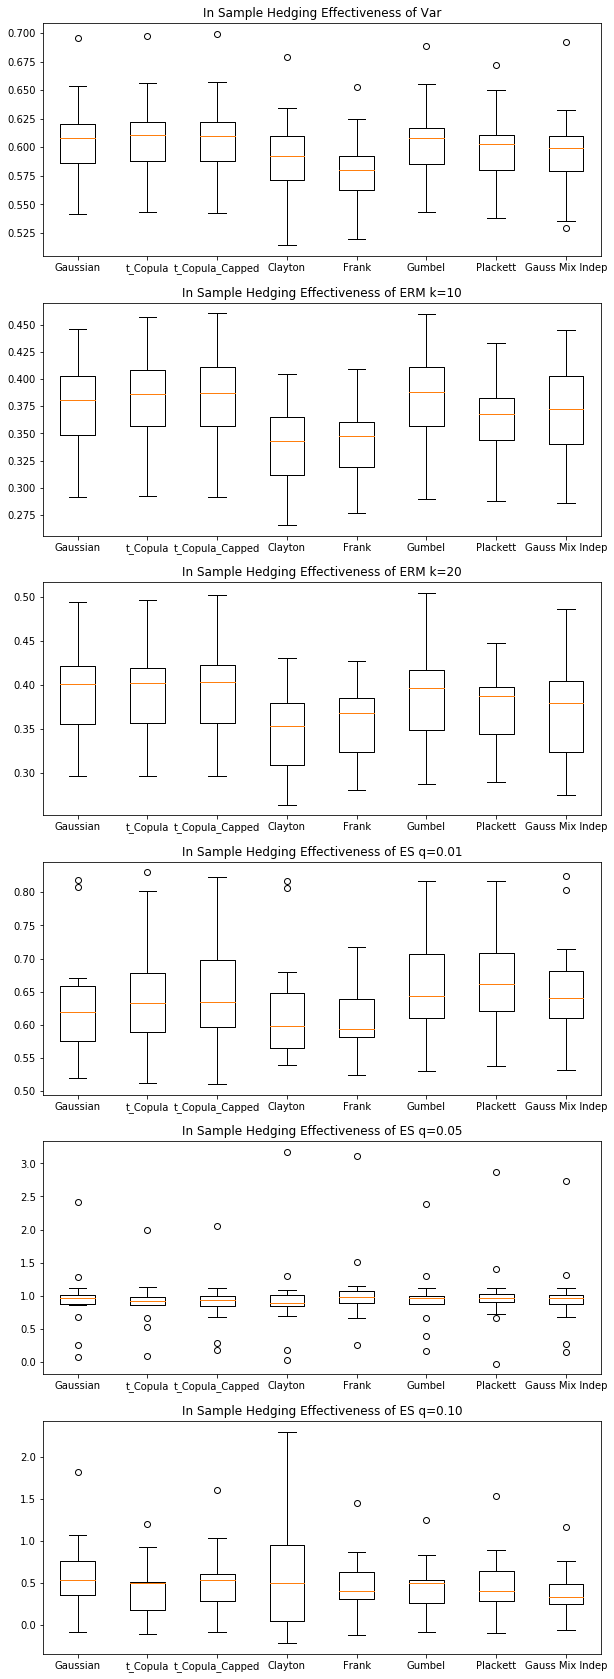

In [345]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'train/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("In Sample Hedging Effectiveness of %s"%name)
    
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"In Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"In Sample Hedging Effectiveness.png", transparent=True)

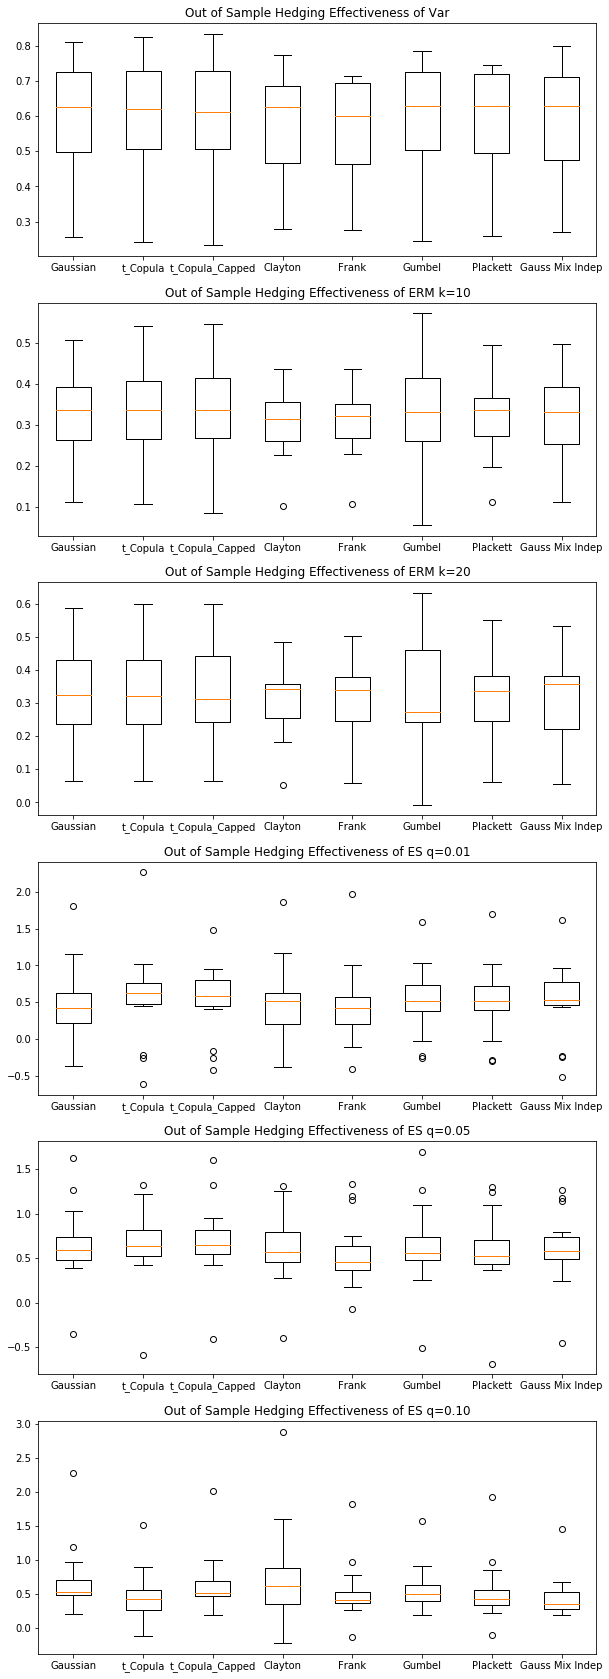

In [344]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'test/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
#     ax[i].set_xticks(np.linspace(1,len(Copulae_names)))
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("Out of Sample Hedging Effectiveness of %s"%name)
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"Out of Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"Out of Sample Hedging Effectiveness.png", transparent=True)